# Random - Greedy

This variation **modifies the semi-greedy construction**. This now consists of an tunable random phase where cities are selected at random and a semi-greedy RCL phase. 

> Example:  If we have a 10 city problem we might compose our GRASP to select the first 5 cities at random.  Our remaining 5 cities are then constructed using the usual semi-greedy procedure.
>> In the GRASP literature we usually specify a percentage **p** of the solution to be constructed randomly as opposed to an absolute number.  (This is a hyper-parameter!).

---

## Imports

In [8]:
import numpy as np
import sys

## `metapy` imports

In [9]:
# install metapy if running in Google Colab
if 'google.colab' in sys.modules:
    !pip install meta-py

In [15]:
from metapy.tsp import tsp_io as io
from metapy.tsp.euclidean import gen_matrix, plot_tour

from metapy.tsp.objective import OptimisedSimpleTSPObjective

from metapy.local_search.hill_climbing import (HillClimber, TweakTwoOpt)

from metapy.tsp.grasp import (SemiGreedyConstructor, 
                              FixedRCLSizer,
                              GRASP)

## Load problem

In [11]:
#load file
file_path = 'https://raw.githubusercontent.com/TomMonks/meta-py/main/data/st70.tsp'

#number of rows in the file that are meta_data
md_rows = 6

#read the coordinates
cities = io.read_coordinates(file_path, md_rows)
matrix = gen_matrix(cities, as_integer=True)

## Implementation

The Random Greedy Algorithm requries a new **tour construction logic**.  We can simply replace `SemiGreedyConstructor` with `RandomPlusGreedyConstructor` (below) when we compose our algorithm.  

> Note that `RandomPlusGreedyConstructor` extends `SemiGreedyConstructor` and overrides the `build()` method

In [13]:
class RandomPlusGreedyConstructor(SemiGreedyConstructor):
    '''
    Random + semi-greedy construction of a tour.
    
    The first n cities of a tour are randomly constructed.  
    The remaining cities are seleted using the standard semi-greedy approach.
    
    For a city i creates a restricted candidate list of size r
    i.e the r shortest distances from city i.  Next city is chosen
    with equal probability. 
    
    Repeats until tour is constructed.
    
    '''
    def __init__(self, rcl_sizer, tour, matrix, p_rand=0.2,
                 random_seed=None):
        '''
        RandomPlusGreedy Constructor method
        
        Params:
        ------
        rcl_sizer: object
            sizes the restricted candidate list
        
        tour: np.ndarray
            vector of city indexes included in problem
            
        matrix: np.ndarray
            matrix of travel costs
            
        p_rand: float, optional (default=0.2)
            Proportion of tour that is randomly constructed
            
        random_seed: int
            used to control sampling provides a
            reproducible result.
        '''
        
        # super class init
        super().__init__(rcl_sizer, tour, matrix,
                       random_seed)
        
        # proportion of tour that is randomly constructed
        self.p_rand = p_rand
        self.n_rand = int(p_rand * len(tour))
        self.n_greedy = len(tour) - self.n_rand - 1
        
    
    def build(self):
        '''
        Random followed by semi-greedy contruction of tour
        
        Returns:
        --------
        np.array
        '''
        # first city in tour
        solution = np.array([self.tour[0]])    
        # next n_rand cities are random
        rand = self.rng.choice(self.tour[1:], size=self.n_rand, replace=False)
        solution = np.append(solution, rand)
        
        # remaining cities are semi-greedy
        for i in range(self.n_greedy):
            r = self.rcl_sizer.get_size()
            rcl = self.get_rcl(r, solution, solution[-1])
            next_city = self.random_from_rcl(rcl)
            solution = np.append(solution, np.array([next_city]))
            
        return solution        

In [14]:
def compose_grasp(tour, matrix, max_iter=50, p_rand=0.2, rcl_size=5, 
                  random_seed=None):
    '''
    Compose the Random Greedy GRASP algorithm
    '''
    # objective function; optimised = numpy
    obj = OptimisedSimpleTSPObjective(-matrix)

    # Two-opt tweaks
    tweaker = TweakTwoOpt()

    # local search = first improvement hill climbing
    ls = HillClimber(obj, tour, tweaker)

    # semi-greedy constructor and RCL sizer
    sizer = FixedRCLSizer(r=rcl_size)
    constructor = RandomPlusGreedyConstructor(sizer, tour, -matrix, 
                                              p_rand=p_rand, 
                                              random_seed=random_seed)

    # bring ingredients together in the GRASP framework
    solver = GRASP(constructor, ls, max_iter=max_iter)

    return solver


Running Random-Greedy GRASP

** GRASP OUTPUT ***
best cost:	-729.0
best solutions:
[ 0 35 15 46 36 57 49 50 64 63 10 55 66 47 53 61 38 24 44 45 26 39 60 33
 20 11 32 59 51  9  4 52  5 40 42 16  8 67 43 29 19 13 27  7 25 48 54 18
  6 31  2 41 17  3  1 23 14 56 62 65 21 58 34 69 30 37 22 12 28 68]


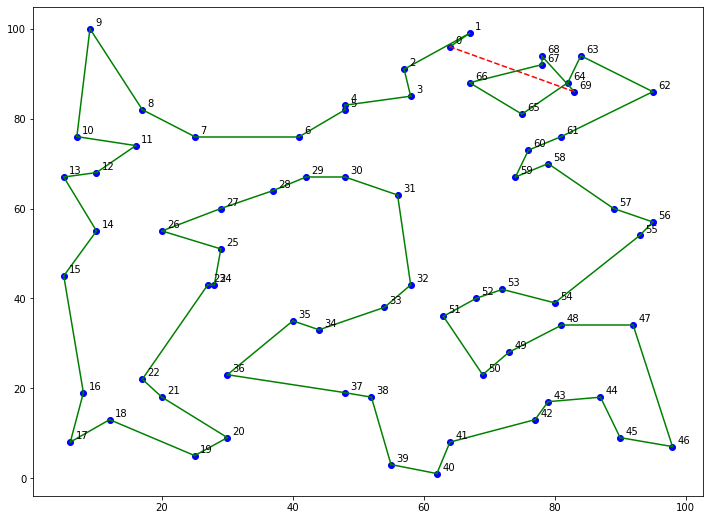

In [18]:
tour = np.arange(len(cities))
solver = compose_grasp(tour, matrix, random_seed=42)
print("\nRunning Random-Greedy GRASP")
solver.solve()

print("\n** GRASP OUTPUT ***")
print(f"best cost:\t{solver.best}")
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))